In [1]:
# Initial imports and enviroment setup
import numpy as np
import sys
import seaborn as sns
import random
import time

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from collections import defaultdict
pio.renderers.default = 'notebook_connected'

import os
sns.set()

os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

if 'notebook' in os.getcwd():
    os.chdir('..')

import gym
import gym.envs.toy_text
import copy 

# Temporal Differencing (TD)

An approach that combines the benifits of Dynamic Programming (DP) and Monte Carlo (MC) by using bootstrapping from DP and the sample-based approach from MC. Below is the implementation of TD(0) where the 0 refers to one less than how many future states are discounted.

$$ V'(s) = V(s) + \alpha[R + \lambda V(s') - V(s)]$$
$$ Q'(s,a) = Q(s,a) + \alpha[R + \lambda Q(s',a') - Q(s',a')]$$

where:
- $V(s)$: Current value of a state
- $V'(s)$: New value of a state
- $s$: current state
- $s'$: next state after an action is taken
- $\alpha$: learning rate
- $a$: action
- $\lambda$: discount factor

# State-Actio-Reward-State-Action (SARSA)

This is in on-policy control algorithm. It sample step by step and updates the Q values where the learning rate can be controlled. 

In [2]:
# SARSA Learning agent class

class SARSAAgent:
    def __init__(self, alpha, epsilon, gamma, get_possible_actions):
        self.get_possible_actions = get_possible_actions
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self._Q = defaultdict(lambda: defaultdict(lambda: 0))

    def get_Q(self, state, action):
        state = tuple(state)
        return self._Q[state][action]

    def set_Q(self, state, action, value):
        state = tuple(state)
        self._Q[state][action] = value

    # carryout SARSA updated based on the sample (S, A, R, S', A')
    def update(self, state, action, reward, next_state, next_action, done):
        state = tuple(state)
        next_state = tuple(next_state)
        if not done:
            td_error = reward + \
                       self.gamma * self.get_Q(next_state, next_action) - \
                       self.get_Q(state, action)
        else:
            td_error = reward - self.get_Q(state, action)

        new_value = self.get_Q(state, action) + self.alpha * td_error
        self.set_Q(state, action, new_value)

    # get argmax for q(s,a)
    def max_action(self, state):
        state = tuple(state)
        actions = self.get_possible_actions(state)
        best_action = []
        best_q_value = float("-inf")

        for action in actions:
            q_s_a = self.get_Q(state, action)
            if q_s_a > best_q_value:
                best_action = [action]
                best_q_value = q_s_a
            elif q_s_a == best_q_value:
                best_action.append(action)
        return np.random.choice(np.array(best_action))

    # choose action as per epsilon-greedy policy
    def get_action(self, state):
        state = tuple(state)
        actions = self.get_possible_actions(state)

        if len(actions) == 0:
            return None

        if np.random.random() < self.epsilon:
            a = np.random.choice(actions)
            return a
        else:
            a = self.max_action(state)
            return a

In [3]:
# training algorithm
def train_sarsa_agent(env, agent, episode_cnt=10000, tmax=10000, anneal_eps=True):
    episode_rewards = []
    for i in range(episode_cnt):
        G = 0
        state = env.reset()
        action = agent.get_action(state)
        for t in range(tmax):
            next_state, reward, done, _ = env.step(action)
            next_action = agent.get_action(next_state)
            agent.update(state, action, reward, next_state, next_action, done)
            G += reward
            if done:
                episode_rewards.append(G)
                # to reduce the exploration probability epsilon over the
                # training period.
                if anneal_eps:
                    agent.epsilon = agent.epsilon * 0.99
                break
            state = next_state
            action = next_action
    return np.array(episode_rewards)

In [4]:
# plot rewards
def plot_rewards(env_name, rewards, label, n = 20):
    plt.title("env={}, Mean reward = {:.1f}".format(env_name,
                                                    np.mean(rewards[-n:])))
    rewards_mean = np.array([np.nan] * len(rewards))
    for i in range(n,len(rewards)):
        rewards_mean[i] = rewards[i-n:i].mean()
    plt.plot(rewards, label=label)
    plt.plot(rewards_mean, label=label + '_mean')
    plt.grid()
    plt.legend()
    plt.show()

In [5]:
# create cliff world environment
#env = gym.envs.toy_text.CliffWalkingEnv()
env = gym.make("CartPole-v1")
print(env.__doc__)

None


In [15]:
# create a SARSA agent
agent = SARSAAgent(
            alpha=0.001,
            epsilon=0.2,
            gamma=0.99,
            get_possible_actions=lambda s : range(env.action_space.n)
        )

#train agent and get rewards for episodes
rewards = train_sarsa_agent(env, agent, episode_cnt = 50000)

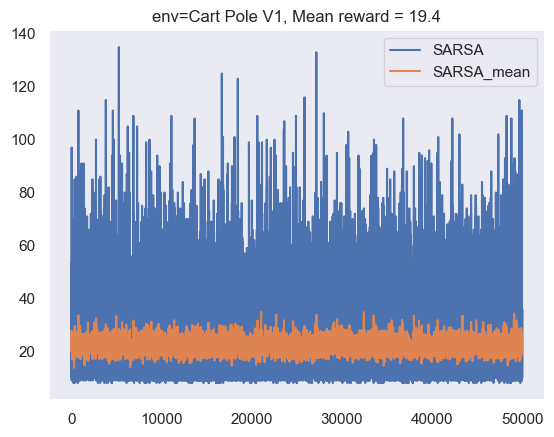

In [16]:
# plot rewards
plot_rewards("Cart Pole V1",rewards, 'SARSA')

In [19]:
tmax = 10000
G = 0

env_run = copy.deepcopy(env)
state = env_run.reset()
action = agent.get_action(state)

for t in range(tmax):
    env_run.render(mode = 'human')
    next_state, reward, done, _ = env_run.step(action)
    next_action = agent.get_action(next_state)
    G += reward
    if done:
        break
    state = next_state
    action = next_action

    time.sleep(0.1)

print(f'lasted for {t} steps')
env_run.close()

lasted for 28 steps


# Q-Learning

This is in on-policy control algorithm. It sample step by step and updates the Q values where the learning rate can be controlled. 

In [26]:
class QLearningAgent:
    def __init__(self, alpha, epsilon, gamma, get_possible_actions):
        self.get_possible_actions = get_possible_actions
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self._Q = defaultdict(lambda: defaultdict(lambda: 0))

    def get_Q(self, state, action):
        state = tuple(state)
        return self._Q[state][action]

    def set_Q(self, state, action, value):
        state = tuple(state)
        self._Q[state][action] = value

    # Q learning update step
    def update(self, state, action, reward, next_state, done):
        state = tuple(state)
        next_state = tuple(next_state)
        if not done:
            best_next_action = self.max_action(next_state)
            td_error = reward + \
                       self.gamma * self.get_Q(next_state, best_next_action) \
                       - self.get_Q(state, action)
        else:
            td_error = reward - self.get_Q(state, action)

        new_value = self.get_Q(state, action) + self.alpha * td_error
        self.set_Q(state, action, new_value)

    # get best A for Q(S,A) which maximizes the Q(S,a) for actions in state S
    def max_action(self, state):
        state = tuple(state)
        actions = self.get_possible_actions(state)
        best_action = []
        best_q_value = float("-inf")

        for action in actions:
            q_s_a = self.get_Q(state, action)
            if q_s_a > best_q_value:
                best_action = [action]
                best_q_value = q_s_a
            elif q_s_a == best_q_value:
                best_action.append(action)
        return np.random.choice(np.array(best_action))

    # choose action as per epsilon-greedy policy for exploration
    def get_action(self, state):
        state = tuple(state)
        actions = self.get_possible_actions(state)

        if len(actions) == 0:
            return None

        if np.random.random() < self.epsilon:
            a = np.random.choice(actions)
            return a
        else:
            a = self.max_action(state)
            return a

In [60]:
def bin_tuple(x, bin_size):
    return tuple([int(xi // bin_size) for xi in x])

In [61]:
# training algorithm
def train_q_agent(env, agent, episode_cnt=10000, tmax=10000, anneal_eps=True, bin_size = None):
    episode_rewards = []
    for i in range(episode_cnt):
        G = 0
        state = env.reset()
        for t in range(tmax):
            if bin_size is not None:
                state = bin_tuple(state, bin_size)
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.update(state, action, reward, next_state, done)
            G += reward
            if done:
                episode_rewards.append(G)
                # to reduce the exploration probability epsilon over the
                # training period.
                if anneal_eps:
                    agent.epsilon = agent.epsilon * 0.99
                break
            state = next_state
    return np.array(episode_rewards)

In [80]:
bin_size = 2

# create a Q Learning agent
q_agent = QLearningAgent(alpha=0.1, epsilon=0.2, gamma=0.995, 
                       get_possible_actions=lambda s : range(env.action_space.n))

#train agent and get rewards for episodes
rewards = train_q_agent(env, q_agent, episode_cnt = 15000, bin_size=bin_size)

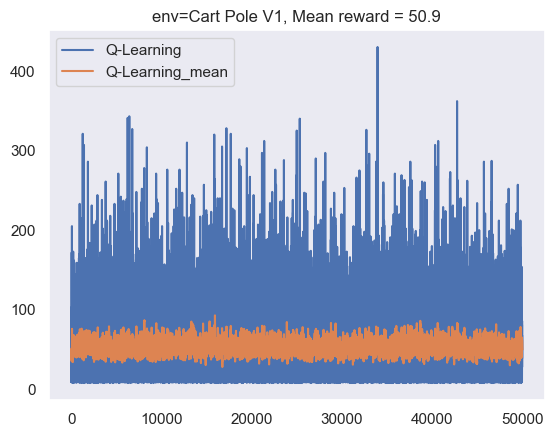

In [81]:
# Plot rewards
plot_rewards("Cart Pole V1",rewards, 'Q-Learning')

In [84]:
tmax = 10000
G = 0

env_run = copy.deepcopy(env)
state = env_run.reset()
q_agent.epsilon = 0
for t in range(tmax):
    env_run.render(mode = 'human')
    
    if bin_size is not None:
        state = bin_tuple(state, bin_size)
    action = q_agent.get_action(state)

    next_state, reward, done, _ = env_run.step(action)
    G += reward
    if done:
        break
    state = next_state

    time.sleep(0.1)

print(f'lasted for {t} steps with a score of {G}')
env_run.close()

lasted for 39 steps with a score of 40.0
